## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open("C://Users//sebas//Case Study NLP//complaints.json","r")# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [5]:
#Assign new column names

new_names = []
for col in df.columns:
    name = col[1:]
    new_names.append(name)

name_change_d = dict(zip(list(df.columns), new_names))
df.rename(columns=name_change_d, inplace=True)    
    
print(df.columns)

Index(['index', 'type', 'id', 'score', 'source.tags', 'source.zip_code',
       'source.complaint_id', 'source.issue', 'source.date_received',
       'source.state', 'source.consumer_disputed', 'source.product',
       'source.company_response', 'source.company', 'source.submitted_via',
       'source.date_sent_to_company', 'source.company_public_response',
       'source.sub_product', 'source.timely', 'source.complaint_what_happened',
       'source.sub_issue', 'source.consumer_consent_provided'],
      dtype='object')


In [6]:
#Assign nan in place of blanks in the complaints column
df['complaints'] = df['source.complaint_what_happened'].replace(r'', np.nan, regex=True)

In [7]:
#Remove all rows where complaints column is nan
#df.drop(columns = ['source.complaint_what_happened'])
df = df[~df['complaints'].isna()]
df

,index,type,id,score,source.tags,source.zip_code,source.complaint_id,source.issue,source.date_received,source.state,...,source.company,source.submitted_via,source.date_sent_to_company,source.company_public_response,source.sub_product,source.timely,source.complaint_what_happened,source.sub_issue,source.consumer_consent_provided,complaints
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,Good morning my name is XXXX XXXX and I apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,I upgraded my XXXX XXXX card in XX/XX/2018 and...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,Chase Card was reported on XX/XX/2019. However...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,"On XX/XX/2018, while trying to book a XXXX XX..."
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for {$1600.00} i de...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78303,complaint-public-v2,complaint,3094545,0.0,Older American,281XX,3094545,"Advertising and marketing, including promotion...",2018-12-07T12:00:00-05:00,NC,...,JPMORGAN CHASE & CO.,Web,2018-12-07T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,After being a Chase Card customer for well ove...,Didn't receive advertised or promotional terms,Consent provided,After being a Chase Card customer for well ove...
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided,"On Wednesday, XX/XX/XXXX I called Chas, my XXX..."
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided,I am not familiar with XXXX pay and did not un...
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided,I have had flawless credit for 30 yrs. I've ha...


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [8]:
# Write your function here to clean the text and remove all the unnecessary elements.
def text_cleaner (text):
    text = text.lower() #make the text lowercase
    text = re.sub(r'\[.*?\]', '', text) #remove text in square brackets
    text = ''.join(char for char in text if char not in string.punctuation) # remove punctuation
    text = ''.join(char for char in text if not char.isdigit()) #remove words containing numbers
    return text

df['complaints_cleaned'] = df['complaints'].apply(lambda x: text_cleaner(x))

In [9]:
#Write your function to Lemmatize the texts
nlp = spacy.load("en_core_web_sm")

def text_lemma(text):
    doc = nlp(text)
    return ' '.join([word.lemma_ for word in doc])
    
df['complaints_lemmatized'] = df['complaints_cleaned'].apply(text_lemma) #lemmatize the wrods

In [10]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaints', 'complaints_lemmatized']]

In [11]:
df_clean

,complaints,complaints_lemmatized
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in xxxx and be tel...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on xxxx however fraudulen...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while try to book a xxxx xxxx tick...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...
...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yr I ve have...


In [12]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # using textblob library to get POS tags
    blob = TextBlob(text)
    return ' '.join([word for (word,tag) in blob.tags if tag == "NN"])

#this column containS lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] = df_clean['complaints_lemmatized'].apply(lambda x: pos_tag(x))

In [13]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,complaints_lemmatized,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in xxxx and be tel...,card xxxx agent upgrade date agent information...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on xxxx however fraudulen...,card application identity consent service cred...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while try to book a xxxx xxxx tick...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...
...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




<Figure size 720x432 with 0 Axes>

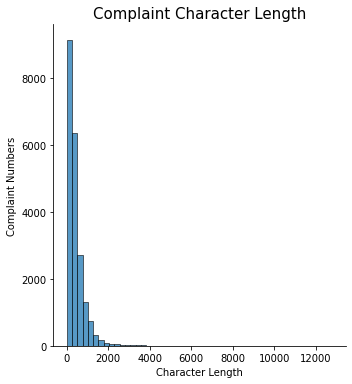

In [14]:
# Write your code here to visualise the data according to the 'Complaint' character length
text_length = [len(text) for text in df_clean["complaint_POS_removed"]]

plt.figure(figsize=(10,6))
sns.displot(text_length, bins=50)
plt.title('Complaint Character Length', fontsize = 15)
plt.ylabel('Complaint Numbers')
plt.xlabel('Character Length')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

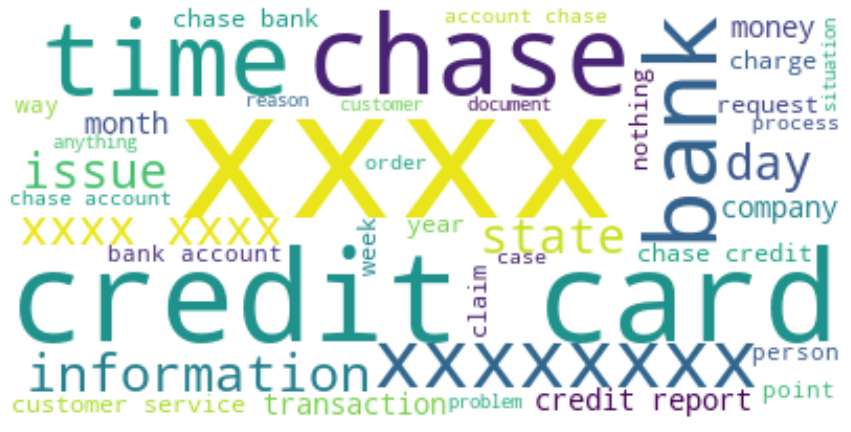

In [15]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

text = " ".join(word for word in df_clean["complaint_POS_removed"])
stopwords = set(nltk.corpus.stopwords.words('english'))
wordcloud = WordCloud(stopwords=stopwords, max_words=40, random_state = 0 ,background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

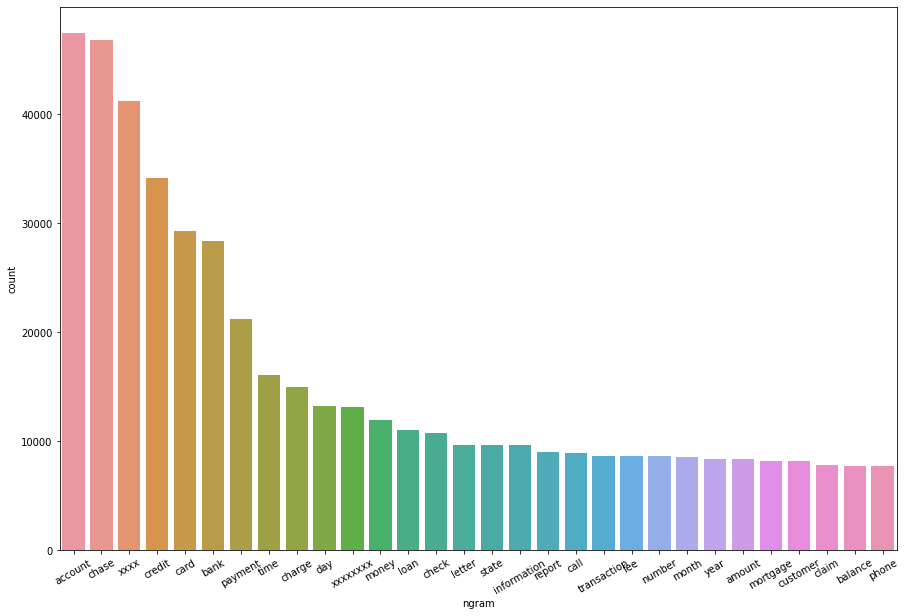

In [17]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
from collections import Counter

text = ' '.join(df_clean['Complaint_clean'])

token = nltk.word_tokenize(text)

unigram_list = Counter(token)
unigram_df = pd.DataFrame(unigram_list.most_common(30), columns = ['ngram', 'count'])

plt.figure(figsize=(15,10))
ax = sns.barplot(data=unigram_df, x='ngram', y="count")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

In [18]:
#Print the top 10 words in the unigram frequency
unigram_list.most_common(10)

[('account', 47492),
 ('chase', 46798),
 ('xxxx', 41205),
 ('credit', 34133),
 ('card', 29287),
 ('bank', 28408),
 ('payment', 21175),
 ('time', 16038),
 ('charge', 14996),
 ('day', 13234)]

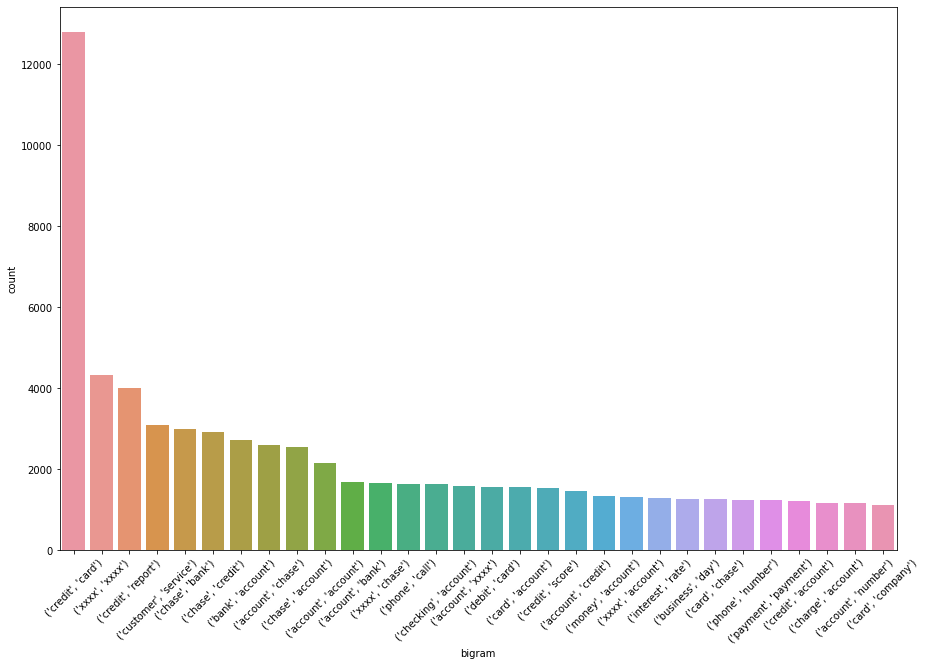

In [19]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
from nltk.util import ngrams

bigrams = ngrams(token,2)
bigram_list = Counter(bigrams)
bigram_df = pd.DataFrame(bigram_list.most_common(30), columns = ['bigram', 'count'])

plt.figure(figsize=(15,10))
ax = sns.barplot(data=bigram_df, x='bigram', y="count")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
plt.show()

In [20]:
#Print the top 10 words in the bigram frequency
bigram_list.most_common(10)

[(('credit', 'card'), 12776),
 (('xxxx', 'xxxx'), 4323),
 (('credit', 'report'), 4002),
 (('customer', 'service'), 3079),
 (('chase', 'bank'), 2981),
 (('chase', 'credit'), 2923),
 (('bank', 'account'), 2722),
 (('account', 'chase'), 2583),
 (('chase', 'account'), 2545),
 (('account', 'account'), 2157)]

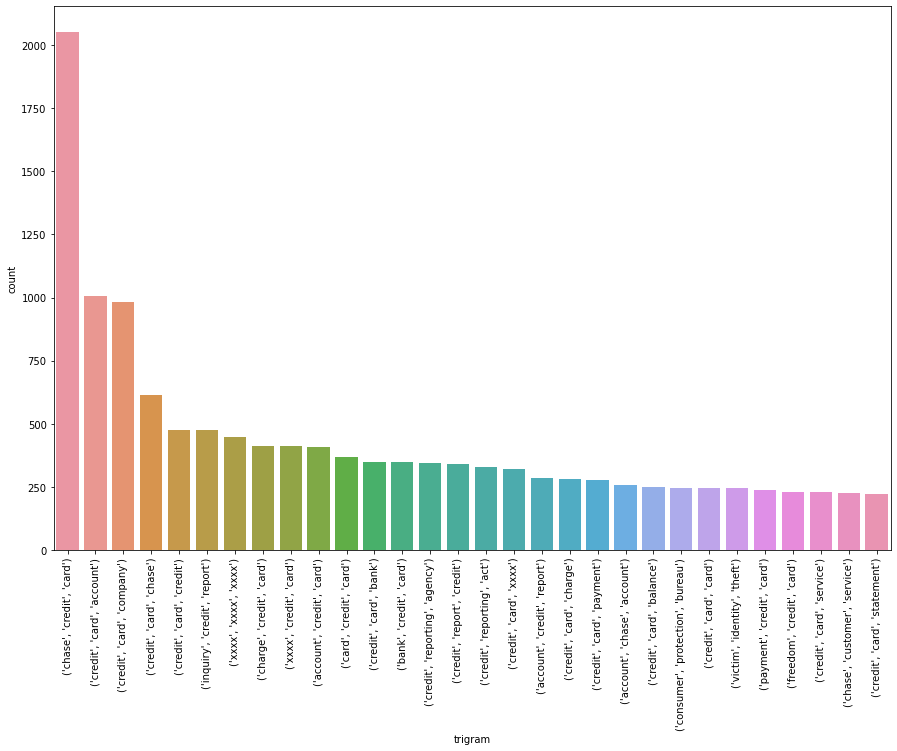

In [21]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = ngrams(token,3)
trigram_list = Counter(trigrams)
trigram_df = pd.DataFrame(trigram_list.most_common(30), columns = ['trigram', 'count'])

plt.figure(figsize=(15,10))
ax = sns.barplot(data=trigram_df, x='trigram', y="count")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

In [22]:
#Print the top 10 words in the trigram frequency
trigram_list.most_common(10)

[(('chase', 'credit', 'card'), 2050),
 (('credit', 'card', 'account'), 1007),
 (('credit', 'card', 'company'), 983),
 (('credit', 'card', 'chase'), 613),
 (('credit', 'card', 'credit'), 477),
 (('inquiry', 'credit', 'report'), 477),
 (('xxxx', 'xxxx', 'xxxx'), 449),
 (('charge', 'credit', 'card'), 413),
 (('xxxx', 'credit', 'card'), 411),
 (('account', 'credit', 'card'), 409)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [23]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [24]:
#All masked texts has been removed
df_clean

,complaints,complaints_lemmatized,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in xxxx and be tel...,card xxxx agent upgrade date agent information...,card agent upgrade date agent information ord...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on xxxx however fraudulen...,card application identity consent service cred...,card application identity consent service cred...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while try to book a xxxx xxxx tick...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [25]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer()

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [26]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
X = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [27]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [28]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=5) #write your code here

In [29]:
nmf_model.fit(X)
len(tfidf.get_feature_names_out())

16424

In [30]:
#Print the Top15 words for each of the topics
components_df = pd.DataFrame(nmf_model.components_, columns=tfidf.get_feature_names_out())

for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(15))
    print('\n')

For topic 1 the words with the highest value are:
account        3.906791
bank           2.109150
check          1.912528
money          1.461436
fund           1.126882
chase          1.097024
deposit        0.914789
branch         0.742564
day            0.715567
number         0.543704
business       0.521300
transaction    0.516480
checking       0.513039
claim          0.454641
customer       0.442554
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
credit         3.012040
card           2.087867
report         1.431294
inquiry        1.065000
chase          0.563533
account        0.530481
score          0.430545
company        0.377672
limit          0.319672
information    0.312817
debt           0.305218
application    0.294258
letter         0.273150
year           0.259777
reporting      0.218866
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
payment      3.824415
balance      0.738300
interest     0.625461
month       

In [31]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_list = ['account','card','loan','credit','customer']

In [32]:
#Assign the best topic to each of the cmplaints in Topic Column
no_of_values = [i for i in range(0,5)]
topic_nmf = dict(zip(no_of_values, topic_list))

#df_clean['Topic'] = topic_list#write your code to assign topics to each rows.
df_clean['Topic'] = nmf_model.transform(X).argmax(axis=1)
df_clean['Topic_nmf'] = df_clean['Topic'].map(topic_nmf)

In [33]:
df_clean

,complaints,complaints_lemmatized,complaint_POS_removed,Complaint_clean,Topic,Topic_nmf
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0,account
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in xxxx and be tel...,card xxxx agent upgrade date agent information...,card agent upgrade date agent information ord...,1,card
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on xxxx however fraudulen...,card application identity consent service cred...,card application identity consent service cred...,1,card
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while try to book a xxxx xxxx tick...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1,card
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0,account
...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1,card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,3,credit
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,3,credit
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...,2,loan


In [34]:
# Print the first 5 Complaint for each of the Topics
df_complaints = df_clean.groupby('Topic').head(5)
df_complaints.sort_values('Topic')

,complaints,complaints_lemmatized,complaint_POS_removed,Complaint_clean,Topic,Topic_nmf
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0,account
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0,account
17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday xxxx branc...,jp chase account debit card tuesday branch cu...,0,account
24,mishandling of this account by Chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0,account
27,I opened an account with chase bank on XXXX an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0,account
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in xxxx and be tel...,card xxxx agent upgrade date agent information...,card agent upgrade date agent information ord...,1,card
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on xxxx however fraudulen...,card application identity consent service cred...,card application identity consent service cred...,1,card
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while try to book a xxxx xxxx tick...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1,card
15,Can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1,card
23,I have a Chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1,card


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [35]:
#Create the dictionary of Topic names and Topics

Topic_names = Topic_names = {0:"Bank Account services",1:"Credit card or prepaid card", 2:"Others",
                             3:"Theft/Dispute Reporting",4:"Mortgage/Loan"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [36]:
df_clean

,complaints,complaints_lemmatized,complaint_POS_removed,Complaint_clean,Topic,Topic_nmf
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank Account services,account
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in xxxx and be tel...,card xxxx agent upgrade date agent information...,card agent upgrade date agent information ord...,Credit card or prepaid card,card
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on xxxx however fraudulen...,card application identity consent service cred...,card application identity consent service cred...,Credit card or prepaid card,card
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while try to book a xxxx xxxx tick...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card or prepaid card,card
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank Account services,account
...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card or prepaid card,card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,Theft/Dispute Reporting,credit
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,Theft/Dispute Reporting,credit
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...,Others,loan


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [37]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services": 0,"Credit card or prepaid card": 1,
               "Others": 2,"Theft/Dispute Reporting": 3,"Mortgage/Loan": 4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [38]:
df_clean

,complaints,complaints_lemmatized,complaint_POS_removed,Complaint_clean,Topic,Topic_nmf
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0,account
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in xxxx and be tel...,card xxxx agent upgrade date agent information...,card agent upgrade date agent information ord...,1,card
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on xxxx however fraudulen...,card application identity consent service cred...,card application identity consent service cred...,1,card
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while try to book a xxxx xxxx tick...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1,card
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0,account
...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1,card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,3,credit
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,3,credit
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...,2,loan


In [39]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_df = df_clean[['Complaint_clean','Topic']]

In [40]:
training_df

,Complaint_clean,Topic
1,morning name stop bank cardmember service ask ...,0
2,card agent upgrade date agent information ord...,1
10,card application identity consent service cred...,1
11,try book ticket offer ticket card information...,1
14,son chase account fund bank account pay money ...,0
...,...,...
78303,card customer decade solicitation credit card ...,1
78309,visa credit card provider claim purchase prote...,3
78310,pay risk provide consumer bank app chase year ...,3
78311,credit yr credit card chase freedom problem b...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [41]:

#Write your code to get the Vector count
countvect = CountVectorizer()
X_countvect= countvect.fit_transform(training_df['Complaint_clean'])

#Write your code here to transform the word vector to tf-idf
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(training_df['Complaint_clean'])

y = training_df['Topic']

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.33, random_state=42, stratify =y)

In [43]:
%%time
# Write your code here to build any 3 models and evaluate them using the required metrics
# Model 1. Logistic Regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', max_iter=1000,random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1736
           1       0.97      0.98      0.97      1583
           2       0.98      0.91      0.94       764
           3       0.96      0.96      0.96      1616
           4       0.96      0.96      0.96      1255

    accuracy                           0.96      6954
   macro avg       0.97      0.96      0.96      6954
weighted avg       0.96      0.96      0.96      6954

Wall time: 2.16 s


Text(0.5, 1.0, 'CONFUSION MATRIX - Logistics Regression\n')

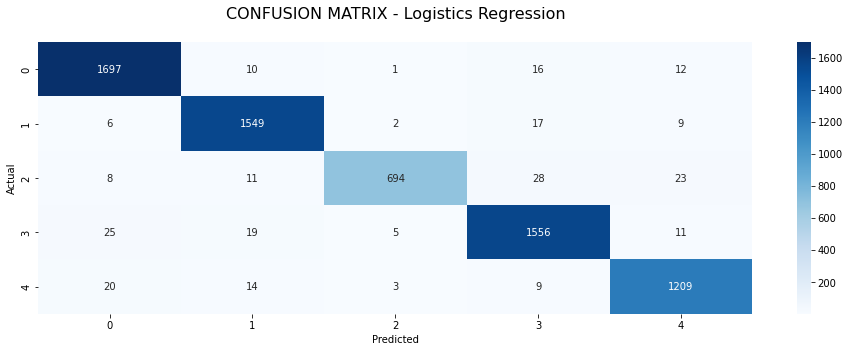

In [44]:
conf_mat=confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(16,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Logistics Regression\n", size=16)

In [45]:
%%time
#Model 2. Decision Tree

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
y_pred = dt.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1736
           1       0.84      0.84      0.84      1583
           2       0.78      0.78      0.78       764
           3       0.79      0.80      0.80      1616
           4       0.85      0.83      0.84      1255

    accuracy                           0.82      6954
   macro avg       0.82      0.81      0.81      6954
weighted avg       0.82      0.82      0.82      6954

Wall time: 2.48 s


Text(0.5, 1.0, 'CONFUSION MATRIX - Decision Tree\n')

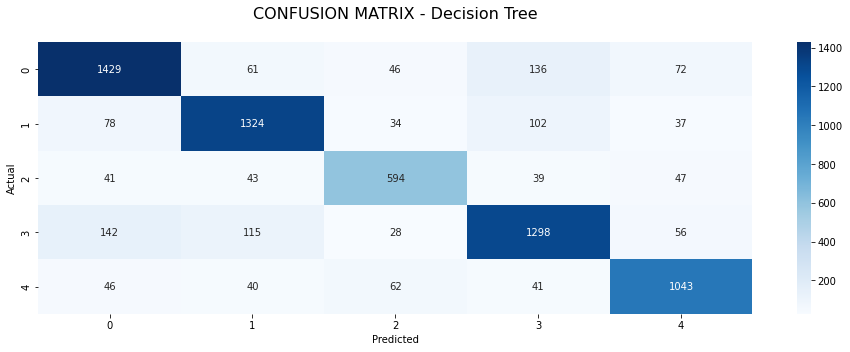

In [46]:
conf_mat=confusion_matrix(y_pred,y_test)

fig, ax = plt.subplots(figsize=(16,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Decision Tree\n", size=16)

In [47]:
%%time
#Model 3. Random Forest

from sklearn.ensemble import RandomForestClassifier

rand_forest = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1736
           1       0.97      0.98      0.97      1583
           2       0.98      0.91      0.94       764
           3       0.96      0.96      0.96      1616
           4       0.96      0.96      0.96      1255

    accuracy                           0.96      6954
   macro avg       0.97      0.96      0.96      6954
weighted avg       0.96      0.96      0.96      6954

Wall time: 22.1 s


Text(0.5, 1.0, 'CONFUSION MATRIX - Random Forest\n')

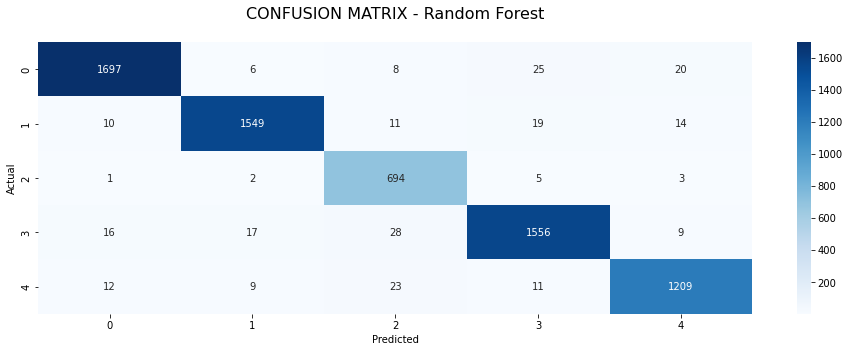

In [48]:
conf_mat=confusion_matrix(y_pred,y_test)

fig, ax = plt.subplots(figsize=(16,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Random Forest\n", size=16)

## Model Selected

### Model 1 (Logistic Regression) was selected

1. Strong weighted average F1-score at 96%.
2. Shorter training time - it took only approximately 2 seconds to complete as compared to 22 seconds to Random Forest model
3. Logistic regression is a less complex model, and it is not as complicated when we are told to explain how it works as compared to a Random Forest model.
